1) Imports & paramètres

transactionnelles importants, une forte concurrence et des enjeux majeurs de fidélisation client. Les données Olist sont relationnelles, temporelles et orientées comportement client.

Problématique :
Comment segmenter les clients de la plateforme Olist à partir de leurs comportements d’achat et prédire l’évolution du chiffre d’affaires et de la demande par segment afin d’optimiser les décisions marketing et commerciales ?

In [39]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


2) Chargement des données

In [19]:
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")

# Parsing dates (important)
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], errors="coerce")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], errors="coerce")

print(customers.shape, orders.shape, order_items.shape, payments.shape, reviews.shape, products.shape)


(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7) (32951, 9)


3) Pré-traitement : agrégations par commande

Agréger items (CA, frais livraison, nb items)

In [20]:
items_agg = (
    order_items.groupby("order_id")
    .agg(
        order_revenue=("price", "sum"),
        order_freight=("freight_value", "sum"),
        nb_items=("order_item_id", "count"),
        nb_products=("product_id", "nunique")
    )
    .reset_index()
)


Agréger paiements (montant total payé, type dominant, max installments)

In [21]:
payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_value_total=("payment_value", "sum"),
        payment_installments_max=("payment_installments", "max"),
        payment_type_mode=("payment_type", lambda x: x.mode().iloc[0] if len(x.mode()) else x.iloc[0])
    )
    .reset_index()
)


Agréger reviews (score + longueur commentaire)

In [22]:
if "review_comment_message" in reviews.columns:
    reviews["review_comment_message"] = reviews["review_comment_message"].fillna("")
    reviews["review_comment_len"] = reviews["review_comment_message"].astype(str).str.len()
else:
    reviews["review_comment_len"] = np.nan

reviews_agg = (
    reviews.groupby("order_id")
    .agg(
        review_score=("review_score", "mean"),
        review_comment_len=("review_comment_len", "mean")
    )
    .reset_index()
)


jointure + visualisation du dataset final

In [23]:
df = (
    orders.merge(customers, on="customer_id", how="left")
          .merge(items_agg, on="order_id", how="left")
          .merge(payments_agg, on="order_id", how="left")
          .merge(reviews_agg, on="order_id", how="left")
)

print(df.shape)
df.head()


(99441, 21)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,payment_type_mode,review_score,review_comment_len
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,29.99,8.72,1.0,1.0,38.71,1.0,voucher,4.0,170.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,118.70,22.76,1.0,1.0,141.46,1.0,boleto,4.0,20.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,159.90,19.22,1.0,1.0,179.12,3.0,credit_card,5.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,45.00,27.20,1.0,1.0,72.20,1.0,credit_card,5.0,105.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,19.90,8.72,1.0,1.0,28.62,1.0,credit_card,5.0,0.0


statistiques descriptives de notre dataset

In [24]:
df.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,review_score,review_comment_len
count,99441,96476,99441,99441.000000,98666.000000,98666.000000,98666.000000,98666.000000,99440.000000,99440.000000,98673.000000,98673.000000
mean,2017-12-31 08:43:12.776581120,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232,35137.474583,137.754076,22.823562,1.141731,1.038098,160.990267,2.930521,4.086793,28.361261
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-09-30 00:00:00,1003.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2017-09-12 14:46:19,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00,11347.000000,45.900000,13.850000,1.000000,1.000000,62.010000,1.000000,4.000000,0.000000
50%,2018-01-18 23:04:36,2018-02-02 19:28:10.500000,2018-02-15 00:00:00,24416.000000,86.900000,17.170000,1.000000,1.000000,105.290000,2.000000,5.000000,0.000000
75%,2018-05-04 15:42:16,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00,58900.000000,149.900000,24.040000,1.000000,1.000000,176.970000,4.000000,5.000000,42.000000
max,2018-10-17 17:30:18,2018-10-17 13:22:46,2018-11-12 00:00:00,99990.000000,13440.000000,1794.960000,21.000000,8.000000,13664.080000,24.000000,5.000000,208.000000
std,NaN,NaN,NaN,29797.938996,210.645145,21.650909,0.538452,0.226456,221.951257,2.715685,1.346274,48.318765


recherche des valeurs manquantes

In [25]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_revenue                     775
order_freight                     775
nb_items                          775
nb_products                       775
payment_value_total                 1
payment_installments_max            1
payment_type_mode                   1
review_score                      768
review_comment_len                768
dtype: int64

Filtrer le périmètre “livré”

In [26]:
df = df[df["order_status"] == "delivered"].copy()


visualiser notre dataset apres jointure en ne prenant que dilivered de la colonne order_status

In [27]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,payment_type_mode,review_score,review_comment_len
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,29.99,8.72,1.0,1.0,38.71,1.0,voucher,4.0,170.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,118.70,22.76,1.0,1.0,141.46,1.0,boleto,4.0,20.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,159.90,19.22,1.0,1.0,179.12,3.0,credit_card,5.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,45.00,27.20,1.0,1.0,72.20,1.0,credit_card,5.0,105.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,19.90,8.72,1.0,1.0,28.62,1.0,credit_card,5.0,0.0


Créer délai de livraison + gérer dates incohérentes

In [28]:
df["delivery_delay_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Retirer les délais négatifs (incohérence)
df = df[df["delivery_delay_days"].notna()]
df = df[df["delivery_delay_days"] >= 0]


Traiter valeurs manquantes (imputations “raisonnables”)

In [29]:
# Si payment_value_total manquant : on prend order_revenue + freight (approx), sinon revenue seule
df["order_revenue"] = df["order_revenue"].fillna(0)
df["order_freight"] = df["order_freight"].fillna(0)

fallback_payment = df["order_revenue"] + df["order_freight"]
df["payment_value_total"] = df["payment_value_total"].fillna(fallback_payment)

# Review score : le client peut ne pas noter → imputation moyenne + (optionnel) indicateur manquant
df["review_missing"] = df["review_score"].isna().astype(int)
df["review_score"] = df["review_score"].fillna(df["review_score"].mean())

# Variables item
df["nb_items"] = df["nb_items"].fillna(1)
df["nb_products"] = df["nb_products"].fillna(1)

# Paiement
df["payment_installments_max"] = df["payment_installments_max"].fillna(1)
df["payment_type_mode"] = df["payment_type_mode"].fillna("unknown")


Gestion outliers (IQR / quantiles) – prix, freight, delay

In [30]:
def clip_iqr(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return s.clip(lower=low, upper=high)

# On "clip" plutôt que supprimer pour garder les clients rares
df["order_revenue_clipped"] = clip_iqr(df["order_revenue"])
df["order_freight_clipped"] = clip_iqr(df["order_freight"])
df["delivery_delay_clipped"] = df["delivery_delay_days"].clip(upper=df["delivery_delay_days"].quantile(0.99))


EDA rapide (tendances / anomalies)

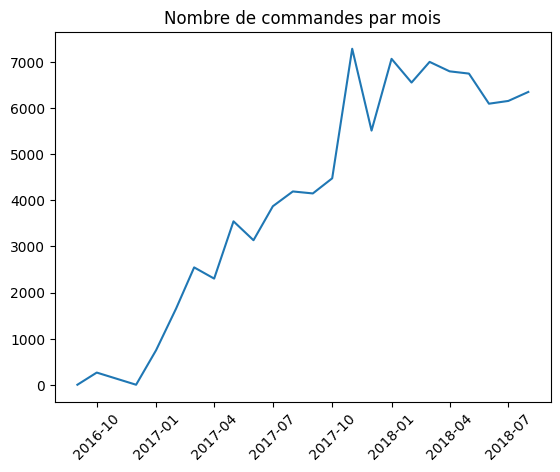

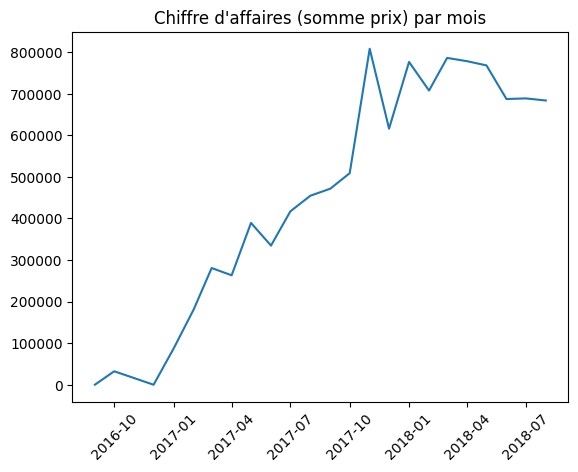

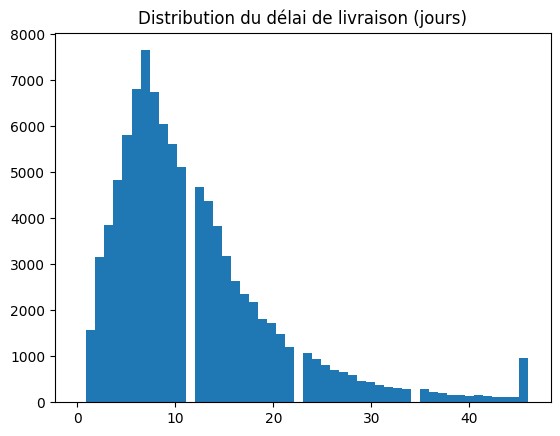

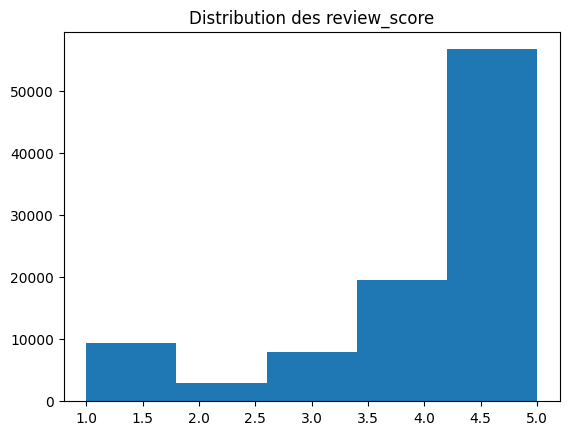

In [31]:
# 6.1 Série temporelle : nb commandes & CA mensuel
df["month"] = df["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

monthly = df.groupby("month").agg(
    orders=("order_id", "nunique"),
    revenue=("order_revenue_clipped", "sum"),
    avg_delay=("delivery_delay_clipped", "mean"),
    avg_review=("review_score", "mean")
).reset_index()

plt.figure()
plt.plot(monthly["month"], monthly["orders"])
plt.title("Nombre de commandes par mois")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.plot(monthly["month"], monthly["revenue"])
plt.title("Chiffre d'affaires (somme prix) par mois")
plt.xticks(rotation=45)
plt.show()

# 6.2 Distribution délais & avis
plt.figure()
plt.hist(df["delivery_delay_clipped"], bins=50)
plt.title("Distribution du délai de livraison (jours)")
plt.show()

plt.figure()
plt.hist(df["review_score"], bins=5)
plt.title("Distribution des review_score")
plt.show()


Feature engineering client (RFM + logistique + satisfaction)

In [32]:
snapshot_date = df["order_purchase_timestamp"].max()

client = (
    df.groupby("customer_unique_id")
    .agg(
        recency_days=("order_purchase_timestamp", lambda x: (snapshot_date - x.max()).days),
        frequency=("order_id", "nunique"),
        monetary=("order_revenue_clipped", "sum"),
        avg_basket=("order_revenue_clipped", "mean"),
        avg_freight=("order_freight_clipped", "mean"),
        avg_delay=("delivery_delay_clipped", "mean"),
        avg_review=("review_score", "mean"),
        review_missing_rate=("review_missing", "mean"),
        installments_mean=("payment_installments_max", "mean")
    )
    .reset_index()
)

client.head(), client.shape


(                 customer_unique_id  recency_days  frequency  monetary  \
 0  0000366f3b9a7992bf8c76cfdf3221e2           111          1    129.90   
 1  0000b849f77a49e4a4ce2b2a4ca5be3f           114          1     18.90   
 2  0000f46a3911fa3c0805444483337064           536          1     69.00   
 3  0000f6ccb0745a6a4b88665a16c9f078           320          1     25.99   
 4  0004aac84e0df4da2b147fca70cf8255           287          1    180.00   
 
    avg_basket  avg_freight  avg_delay  avg_review  review_missing_rate  \
 0      129.90        12.00        6.0         5.0                  0.0   
 1       18.90         8.29        3.0         4.0                  0.0   
 2       69.00        17.22       25.0         3.0                  0.0   
 3       25.99        17.63       20.0         4.0                  0.0   
 4      180.00        16.89       13.0         5.0                  0.0   
 
    installments_mean  
 0                8.0  
 1                1.0  
 2                8.0  


Segmentation (Clustering) : KMeans + DBSCAN

In [33]:
features = [
    "recency_days", "frequency", "monetary",
    "avg_basket", "avg_freight", "avg_delay",
    "avg_review", "review_missing_rate", "installments_mean"
]

X = client[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [34]:
scores = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    scores.append((k, sil, dbi))

scores_df = pd.DataFrame(scores, columns=["k", "silhouette", "davies_bouldin"])
scores_df


,k,silhouette,davies_bouldin
0,2,0.301932,1.664737
1,3,0.280335,1.714641
2,4,0.169852,1.686899
3,5,0.178907,1.387141
4,6,0.182490,1.418629
5,7,0.182694,1.545421
6,8,0.203345,1.374240


In [35]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
client["segment_kmeans"] = kmeans.fit_predict(X_scaled)

print("Silhouette:", silhouette_score(X_scaled, client["segment_kmeans"]))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, client["segment_kmeans"]))


Silhouette: 0.16985205185067645
Davies-Bouldin: 1.6868991154748598


In [36]:
seg_profile = client.groupby("segment_kmeans")[features].mean().round(2)
seg_size = client["segment_kmeans"].value_counts().sort_index()

seg_profile, seg_size


(                recency_days  frequency  monetary  avg_basket  avg_freight  \
 segment_kmeans                                                               
 0                     232.33       1.07    253.70      242.12        28.21   
 1                     393.65       1.02     74.82       73.59        17.31   
 2                     123.77       1.03     73.92       72.31        16.52   
 3                     232.08       1.02     95.70       94.44        22.11   
 
                 avg_delay  avg_review  review_missing_rate  installments_mean  
 segment_kmeans                                                                 
 0                   12.47        4.25                 0.01               5.32  
 1                   10.91        4.58                 0.01               2.46  
 2                    8.73        4.62                 0.00               2.02  
 3                   22.32        1.80                 0.01               2.61  ,
 segment_kmeans
 0    19614
 1    262

Modèles supervisés
9.1 Régression : prédire la “valeur client” (monetary)

In [42]:
from sklearn.metrics import root_mean_squared_error
target_reg = "monetary"
X_reg = client[features].copy()
y_reg = client[target_reg]

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_estimators=300)
}

reg_results = []
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = root_mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    reg_results.append((name, mae, rmse, r2))

pd.DataFrame(reg_results, columns=["model", "MAE", "RMSE", "R2"]).sort_values("RMSE")


,model,MAE,RMSE,R2
0,LinearRegression,1.409221e-14,2.221646e-14,1.000000
1,RandomForestRegressor,1.864218e-02,1.251424e+00,0.999805


9.2 Classification : prédire “high value client”

In [43]:
threshold = client["monetary"].quantile(0.75)
client["high_value"] = (client["monetary"] >= threshold).astype(int)

X_clf = client[features]
y_clf = client["high_value"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=400)
}

clf_results = []
for name, model in clf_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, proba) if proba is not None else np.nan

    clf_results.append((name, acc, f1, auc))

pd.DataFrame(clf_results, columns=["model", "Accuracy", "F1", "ROC_AUC"]).sort_values("ROC_AUC", ascending=False)


,model,Accuracy,F1,ROC_AUC
1,RandomForestClassifier,1.000000,1.000000,1.0
0,LogisticRegression,0.999893,0.999786,1.0


In [44]:
best_clf = RandomForestClassifier(random_state=42, n_estimators=400)
best_clf.fit(X_train, y_train)
pred = best_clf.predict(X_test)

print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14002
           1       1.00      1.00      1.00      4668

    accuracy                           1.00     18670
   macro avg       1.00      1.00      1.00     18670
weighted avg       1.00      1.00      1.00     18670

Confusion matrix:
 [[14002     0]
 [    0  4668]]


In [45]:
# Rejoindre le segment client dans df
df_seg = df.merge(client[["customer_unique_id", "segment_kmeans"]], on="customer_unique_id", how="left")

monthly_seg = (
    df_seg.groupby(["month", "segment_kmeans"])
    .agg(
        revenue=("order_revenue_clipped", "sum"),
        orders=("order_id", "nunique"),
        avg_delay=("delivery_delay_clipped", "mean"),
        avg_review=("review_score", "mean")
    )
    .reset_index()
)

monthly_seg.head()


,month,segment_kmeans,revenue,orders,avg_delay,avg_review
0,2016-09-01,3,134.97,1,46.000000,1.000000
1,2016-10-01,0,16750.36,61,18.163934,4.248462
2,2016-10-01,1,12035.74,164,16.695122,4.464367
3,2016-10-01,2,186.69,4,18.250000,4.750000
4,2016-10-01,3,3428.79,36,29.611111,1.476560


In [48]:
# Installer si besoin: pip install statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

seg_id = 0
ts = monthly_seg[monthly_seg["segment_kmeans"] == seg_id].copy()
ts = ts.sort_values("month").set_index("month")

var_df = ts[["revenue", "orders", "avg_delay"]].copy()

# 1) Stationnarité (ADF p-value)
for col in var_df.columns:
    p = adfuller(var_df[col].dropna())[1]
    print(col, "ADF p-value =", round(p, 4))

# 2) Différenciation si nécessaire
var_df_diff = var_df.diff().dropna()

# 3) Choix du lag par AIC
model = VAR(var_df_diff)
order_res = model.select_order(maxlags=3)
print(order_res.summary())

best_lag = order_res.selected_orders["aic"] or 2
var_model = model.fit(best_lag)
print(var_model.summary())

# 4) Forecast
steps = 3  # 3 mois
forecast = var_model.forecast(var_df_diff.values[-best_lag:], steps=steps)
forecast_df = pd.DataFrame(forecast, columns=var_df.columns)

forecast_df


revenue ADF p-value = 0.1168
orders ADF p-value = 0.1099
avg_delay ADF p-value = 0.5024
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      28.73*      28.88*  3.017e+12*      28.75*
1       28.78       29.37   3.243e+12       28.84
2       28.87       29.90   4.053e+12       28.98
3       29.05       30.52   6.982e+12       29.20
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Dec, 2025
Time:                     14:50:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    30.1474
Nobs:                     18.0000    HQIC:                   29.2519
Log likelihood:          -317.601    FPE:                4.98913e+12
AIC:                      29.1087    Det(Omega_mle):     1.86

c:\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,revenue,orders,avg_delay
0,29133.074730,124.068502,-1.189742
1,-17737.154277,-80.718731,0.104513
2,34684.554795,148.130616,-0.918033


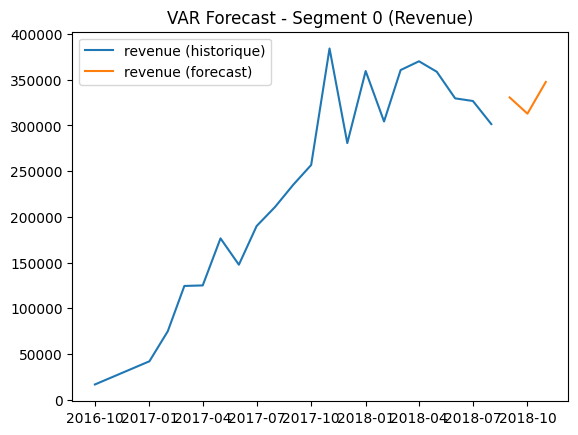

In [49]:
# Reconstruction "niveau" approximative (à partir du dernier point)
last_level = var_df.iloc[-1]
forecast_level = forecast_df.cumsum() + last_level.values

forecast_level.index = pd.date_range(start=var_df.index[-1] + pd.offsets.MonthBegin(1),
                                     periods=steps, freq="MS")

plt.figure()
plt.plot(var_df.index, var_df["revenue"], label="revenue (historique)")
plt.plot(forecast_level.index, forecast_level["revenue"], label="revenue (forecast)")
plt.title(f"VAR Forecast - Segment {seg_id} (Revenue)")
plt.legend()
plt.show()


In [50]:
# Exemple : règles simples basées sur les moyennes par segment
profile = client.groupby("segment_kmeans").agg(
    clients=("customer_unique_id", "count"),
    monetary=("monetary", "mean"),
    frequency=("frequency", "mean"),
    recency=("recency_days", "mean"),
    delay=("avg_delay", "mean"),
    review=("avg_review", "mean")
).round(2)

profile


,clients,monetary,frequency,recency,delay,review
segment_kmeans,,,,,,
0,19614,253.70,1.07,232.33,12.47,4.25
1,26274,74.82,1.02,393.65,10.91,4.58
2,35041,73.92,1.03,123.77,8.73,4.62
3,12421,95.70,1.02,232.08,22.32,1.80
